In [34]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as npl
from numpy import inf
from scipy.optimize import minimize
from tqdm.notebook import tqdm

sys.path.append("../src")

from data_utils.synthetic_data_utils import data_type_dict

In [55]:
def calc_regret(lamb_root, x_arr_train, y_vec, x_vec_test, svd_res):
    lamb = lamb_root ** 2

    N, M = x_arr_train.shape
    u, s, vh = svd_res
    s_inv = 1 / (s + lamb)

    #     P = npl.inv(phi_train.T @ phi_train + lamb * np.eye(M))

    #     s_inv[s_inv == inf] = 0

    # Cacl
    P = vh.T @ np.diag(s_inv) @ u.T
    x_t_P_x = float(np.abs(x_vec_test.T @ P @ x_vec_test))
    x_t_P_square_x = float(np.abs(x_vec_test.T @ P @ P @ x_vec_test))
    K0 = 1 + x_t_P_x

    theta = P @ x_arr_train.T @ y_vec

    theta_t_P_x = float(theta.T @ P @ x_vec_test)
    epsilon_n = y_vec.squeeze() - (x_arr_train @ theta).squeeze()

    var = float(np.mean(epsilon_n ** 2))
    #     var = 1.0
    # Calc first element
    prefix = 1 / (2 * var)
    #     a1 = prefix * ((lamb * theta_t_P_x) ** 2) / (K0 + lamb * x_t_P_square_x)
    a1 = prefix * ((lamb * theta_t_P_x) ** 2) / (1 + lamb * x_t_P_square_x)

    #     a2 = -prefix * np.sum(epsilon_n ** 2)
    a2 = 0

    a3 = -prefix * float(lamb * theta.T @ theta)
    a4 = np.log(K0)

    #     a5 = -0.5 * np.log(K0 + lamb * x_t_P_square_x)
    a5 = -0.5 * np.log(1 + lamb * x_t_P_square_x)

#     a6 = -0.5 * N * np.log(2 * np.pi * var)
    a6 = 0
#     a7 = 0.5 * np.log(lamb)
    a7 = 0 
    res_dict = {
        "a1": a1,
        "a2": a2,
        "a3": a3,
        "a3": a3,
        "a4": a4,
        "a5": a5,
        "a6": a6,
        "a7": a7,
    }
    return float(a1 + a2 + a3 + a4 + a5 + a6 + a7)  # , res_dict

In [56]:
def fit_least_squares_estimator(
    x_arr: np.ndarray, y_vec: np.ndarray, lamb: float = 0.0
) -> np.ndarray:
    """
    Fit least squares estimator
    :param x_arr: The training set features matrix. Each row represents an example.
    :param y_vec: the labels vector.
    :param lamb: regularization term.
    :return: the fitted parameters. A column vector
    """
    n, m = x_arr.shape
    phi_t_phi_plus_lamb = x_arr.T @ x_arr + lamb * np.eye(m)

    # If invertible, regular least squares
    inv = npl.inv(phi_t_phi_plus_lamb)
    theta = inv @ x_arr.T @ y_vec

    theta = np.expand_dims(theta, 1)
    return theta

In [57]:
model_degree = 100
x_test_max = 2.0
x_test_min = -2.0
dx_test = 0.01
x_train = [-0.7, -0.6, 0.05, 0.1, 0.25, 0.3, 0.35, 0.5, 0.55, 0.6]
y_train = [-0.1, -0.2, -2.0, -1.0, -0.5, -0.3, 0.1, 0.5, 0.2, 0.1]
data_type = "polynomial"
lamb = 0

In [58]:
def calc_c2_divide_c1(theta, phi_test, lamb, phi_train):
    N, M = phi_train.shape
    P = npl.inv(phi_train.T @ phi_train + lamb * np.eye(M))
    c2_divide_c1 = (
        lamb
        * theta.T
        @ P
        @ phi_test
        / (1 + phi_test.T @ P @ phi_test + lamb * phi_test.T @ P @ P @ phi_test)
    )
    return float(c2_divide_c1)


# Create trainset
data_class = data_type_dict[data_type]
data_h = data_class(x_train, y_train, model_degree)

# Execute x_test
x_test_list = np.arange(x_test_min, x_test_max, dx_test).round(3)
lamb = 1

phi_train = data_h.phi_train


theta_erm = fit_least_squares_estimator(data_h.phi_train, y_train)
theta_lamb = fit_least_squares_estimator(data_h.phi_train, y_train, lamb=lamb)
y_hat_list, y_hat_lamb_list, y_hat_pnml_list = [], [], []
c2_divide_c1_list = []
for x_test in x_test_list:
    phi_test = data_h.convert_point_to_features(x_test, model_degree)
    y_hat = theta_erm.T @ phi_test
    y_hat_list.append(float(y_hat))

    y_hat_lamb = theta_lamb.T @ phi_test
    y_hat_lamb_list.append(float(y_hat_lamb))

    c2_divide_c1 = calc_c2_divide_c1(theta_lamb, phi_test, lamb, phi_train)

    y_hat_pnml = y_hat_lamb + c2_divide_c1
    c2_divide_c1_list.append(c2_divide_c1)
    y_hat_pnml_list.append(float(y_hat_pnml))

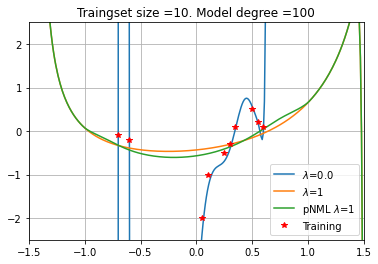

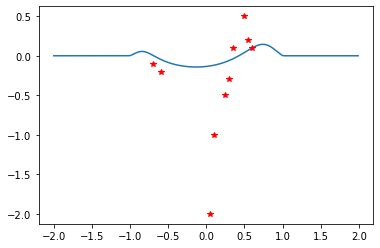

In [59]:
plt.plot(x_test_list, y_hat_list, label=r"$\lambda$=0.0")
plt.plot(x_test_list, y_hat_lamb_list, label=r"$\lambda$={}".format(lamb))
plt.plot(x_test_list, y_hat_pnml_list, label=r"pNML $\lambda$={}".format(lamb))

plt.plot(x_train, y_train, "r*", label="Training")
plt.title("Traingset size ={}. Model degree ={}".format(len(x_train), model_degree))
plt.legend()
plt.grid()
plt.xlim(-1.5, 1.5)
plt.ylim(-2.5, 2.5)
plt.show()

plt.plot(x_test_list, c2_divide_c1_list)
plt.plot(x_train, y_train, "r*", label="Training")
plt.show()

In [60]:
lambs = np.sort(
    np.unique(
        np.hstack(
            (
                np.logspace(-12, -9, 100),
                np.logspace(-9, -6, 100),
                np.logspace(-6, -3, 100),
                np.logspace(-3, -1, 100),
                np.logspace(-1, 1, 100),
                np.logspace(1, 3, 100),
                np.logspace(3, 6, 100),
                np.logspace(6, 9, 100),
                #                 np.linspace(1e-12, 10, 1000),
            )
        )
    )
)


rank = min(phi_train.shape)
h, s, vh = npl.svd(phi_train.T @ phi_train, hermitian=True)
s[rank:] = 0
svd_res = h, s, vh
y_vec = np.array(y_train)[: np.newaxis]


best_lamb_list = []
best_lamb_y_hat_list = []
best_res_dicts = []
for x_test in tqdm(x_test_list):
    phi_test = data_h.convert_point_to_features(x_test, model_degree)

    regrets, res_dicts = [], []
    for lamb in lambs:
        regret, res_dict = calc_regret(phi_train, y_vec, phi_test, svd_res, lamb=lamb)
        regrets.append(regret)
        res_dicts.append(res_dict)

    best_idx = np.argmin(regrets)
    best_lamb = lambs[best_idx]
    best_lamb_list.append(best_lamb)

    theta_best = fit_least_squares_estimator(phi_train, y_train, lamb=best_lamb)
    y_hat_lamb = theta_best.T @ phi_test
    best_lamb_y_hat_list.append(float(y_hat_lamb))
    best_res_dicts.append(res_dicts[best_idx])

  0%|          | 0/400 [00:00<?, ?it/s]

TypeError: calc_regret() got an unexpected keyword argument 'lamb'

In [63]:
# with scipy minimize

rank = min(phi_train.shape)
h, s, vh = npl.svd(phi_train.T @ phi_train, hermitian=True)
s[rank:] = 0
svd_res = h, s, vh
y_vec = np.array(y_train)[: np.newaxis]


best_lamb_list = []
best_lamb_y_hat_list = []
best_res_dicts = []
for x_test in tqdm(x_test_list):
    phi_test = data_h.convert_point_to_features(x_test, model_degree)

    regrets, res_dicts = [], []

    x0 = 1e-9
    res = minimize(
        calc_regret,
        x0,
        args=(phi_train, y_vec, phi_test, svd_res),
        options={ "disp": False},
    )

    lamb_root = float(res.x)
    regret = calc_regret(lamb_root, phi_train, y_vec, phi_test, svd_res)
    best_lamb = lamb_root ** 2
    best_lamb_list.append(best_lamb)

    theta_best = fit_least_squares_estimator(phi_train, y_train, lamb=best_lamb)
    y_hat_lamb = theta_best.T @ phi_test
    best_lamb_y_hat_list.append(float(y_hat_lamb))

  0%|          | 0/400 [00:00<?, ?it/s]

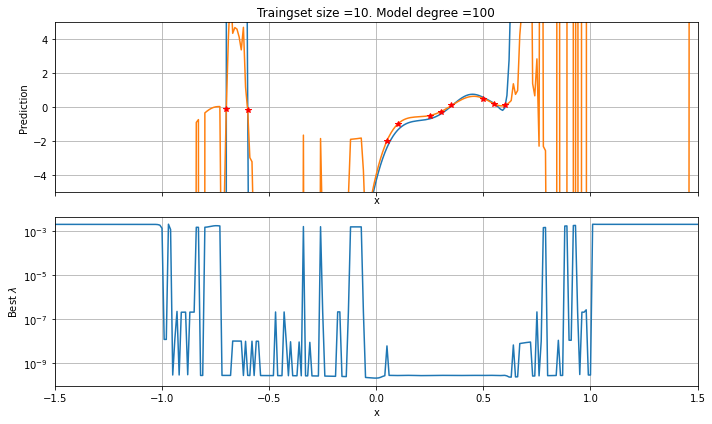

2.0378904214460927e-10 0.0021135723173777996


In [64]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax = axs[0]
ax.plot(x_test_list, y_hat_list, label="ERM")
ax.plot(x_test_list, best_lamb_y_hat_list, label=r"Best $\lambda$")
ax.plot(x_train, y_train, "r*", label="Training")


ax.set_title("Traingset size ={}. Model degree ={}".format(len(x_train), model_degree))
ax.set_ylabel("Prediction")
ax.set_xlabel("x")
ax.grid(True)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-5, 5)

ax = axs[1]
ax.plot(x_test_list, best_lamb_list)
ax.plot(x_train, [0] * len(x_train), "r*", label="Training")

ax.set_ylabel(r"Best $\lambda$")
ax.set_xlabel("x")
ax.set_yscale("log")
ax.grid(True)


# ax = axs[2]
# a1 = [res_dict["a1"] for res_dict in best_res_dicts]
# a2 = [res_dict["a3"] for res_dict in best_res_dicts]
# a3 = [res_dict["a2"] for res_dict in best_res_dicts]
# ax.plot(x_test_list, a1, label="a1")
# ax.plot(x_test_list, a2, label="a2")
# ax.plot(x_test_list, a3, label="a3")
# ax.set_xlabel("x")
# ax.grid(True)
# ax.legend()

plt.tight_layout()
plt.show()

print(np.min(best_lamb_list), np.max(best_lamb_list))

<ipython-input-7-9223c9285dd9>:32: RuntimeWarning: invalid value encountered in log
  a4 = np.log(K0)


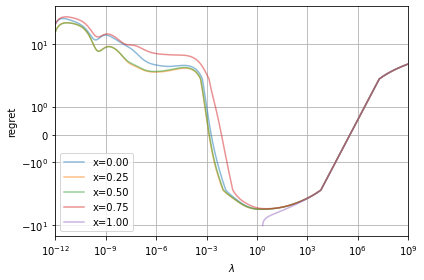

In [9]:
x_test_to_eval = np.linspace(0, 1, 5)
regrets_per_x_test = []
for x_test in x_test_to_eval:
    phi_test = data_h.convert_point_to_features(x_test, model_degree)

    regrets = []
    res_dicts = []
    for lamb in lambs:
        regret, res_dict = calc_regret(phi_train, y_vec, phi_test, svd_res, lamb=lamb)
        regrets.append(regret)
        res_dicts.append(res_dict)
    regrets_per_x_test.append(regrets)

fig, ax = plt.subplots(1, 1)
colors = ["C0", "C1", "C2", "C3", "C4"]
for i, (x_test, regrets, color) in enumerate(
    zip(x_test_to_eval, regrets_per_x_test, colors)
):

    ax.plot(lambs, regrets, label="x={:.2f}".format(x_test), color=color, alpha=0.5)


ax.grid(True)
ax.set_yscale("symlog")
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel("regret")
ax.set_xlim(np.min(lambs), np.max(lambs))
ax.legend()
plt.tight_layout()
plt.show()

<ipython-input-7-9223c9285dd9>:32: RuntimeWarning: invalid value encountered in log
  a4 = np.log(K0)
<ipython-input-13-6f13cef895a4>:26: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(0, 10)


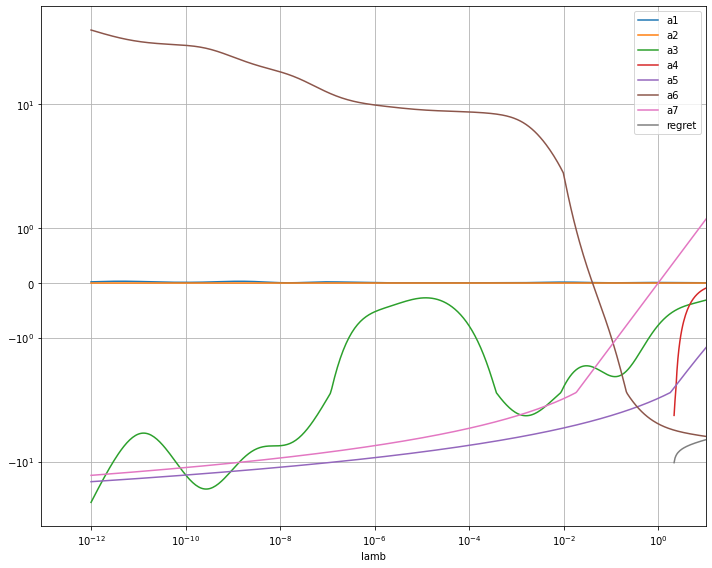

In [13]:
x_test = 1.0
phi_test = data_h.convert_point_to_features(x_test, model_degree)

regrets = []
res_dicts = []
for lamb in lambs:
    regret, res_dict = calc_regret(phi_train, y_vec, phi_test, svd_res, lamb=lamb)
    regrets.append(regret)
    res_dicts.append(res_dict)

keys = list(res_dicts[0].keys())
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for key in keys:
    ax.plot(
        lambs, [float(res_dict[key]) for res_dict in res_dicts], label=key, alpha=1.0
    )
ax.plot(lambs, regrets, label="regret", alpha=1.0)

min_idx = np.argmin(regrets)
ax.plot(lambs[min_idx], regrets[min_idx], "*", alpha=1.0)

ax.grid()
ax.set_xlabel("lamb")
ax.set_yscale("symlog")
ax.set_xscale("log")
ax.set_xlim(0, 10)
ax.legend()
plt.tight_layout()
plt.show()

In [21]:
x_vec_test = phi_test
x_arr_train = phi_train

N, M = x_arr_train.shape
u, s, vh = svd_res
s_inv = 1 / (s + lamb)

#     P = npl.inv(phi_train.T @ phi_train + lamb * np.eye(M))

s_inv[s_inv == inf] = 0

# Cacl
P = vh.T @ np.diag(s_inv) @ u.T
x_t_P_x = x_vec_test.T @ P @ x_vec_test
x_t_P_square_x = x_vec_test.T @ P @ P @ x_vec_test
K0 = 1 + x_t_P_x
K0

array([[-1.81099044e+13]])

In [19]:
lamb = 1e-12

In [25]:
x_t_P_square_x

array([[8.12669959e+25]])

In [24]:
s_inv

array([9.33952395e-02, 4.56105832e-01, 3.95661845e+00, 6.72658496e+01,
       3.13928135e+02, 7.51335416e+03, 4.82785534e+05, 1.84290689e+07,
       5.97711298e+08, 1.88010275e+11, 1.00000000e+12, 1.00000000e+12,
       1.00000000e+12, 1.00000000e+12, 1.00000000e+12, 1.00000000e+12,
       1.00000000e+12, 1.00000000e+12, 1.00000000e+12, 1.00000000e+12,
       1.00000000e+12, 1.00000000e+12, 1.00000000e+12, 1.00000000e+12,
       1.00000000e+12, 1.00000000e+12, 1.00000000e+12, 1.00000000e+12,
       1.00000000e+12, 1.00000000e+12, 1.00000000e+12, 1.00000000e+12,
       1.00000000e+12, 1.00000000e+12, 1.00000000e+12, 1.00000000e+12,
       1.00000000e+12, 1.00000000e+12, 1.00000000e+12, 1.00000000e+12,
       1.00000000e+12, 1.00000000e+12, 1.00000000e+12, 1.00000000e+12,
       1.00000000e+12, 1.00000000e+12, 1.00000000e+12, 1.00000000e+12,
       1.00000000e+12, 1.00000000e+12, 1.00000000e+12, 1.00000000e+12,
       1.00000000e+12, 1.00000000e+12, 1.00000000e+12, 1.00000000e+12,
      